In [1]:
from functions import get_ordered_layout_list
import functions as F
import gpt_function
import layoutparser as lp
import re
#import json

In [2]:
from dotenv import load_dotenv
import os
# Load environment variables from .env file
load_dotenv()
api_key = os.environ.get("OPENAI_API_KEY")

In [3]:
# overall good but no math
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})


# # has math, but no title, overall not accurate image
# model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config', 
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                  label_map={1: "TextRegion", 2: "ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})

# # only for math part
# model = lp.Detectron2LayoutModel('lp://MFD/faster_rcnn_R_50_FPN_3x/config', 
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                  label_map={1: "Equation"})


    # Load the deep layout model from the layoutparser API 
    # For all the supported model, please check the Model 
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [4]:
layout_list, image_list = get_ordered_layout_list(model, 'test.pdf')

/Users/melindadong/miniforge3/envs/test/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


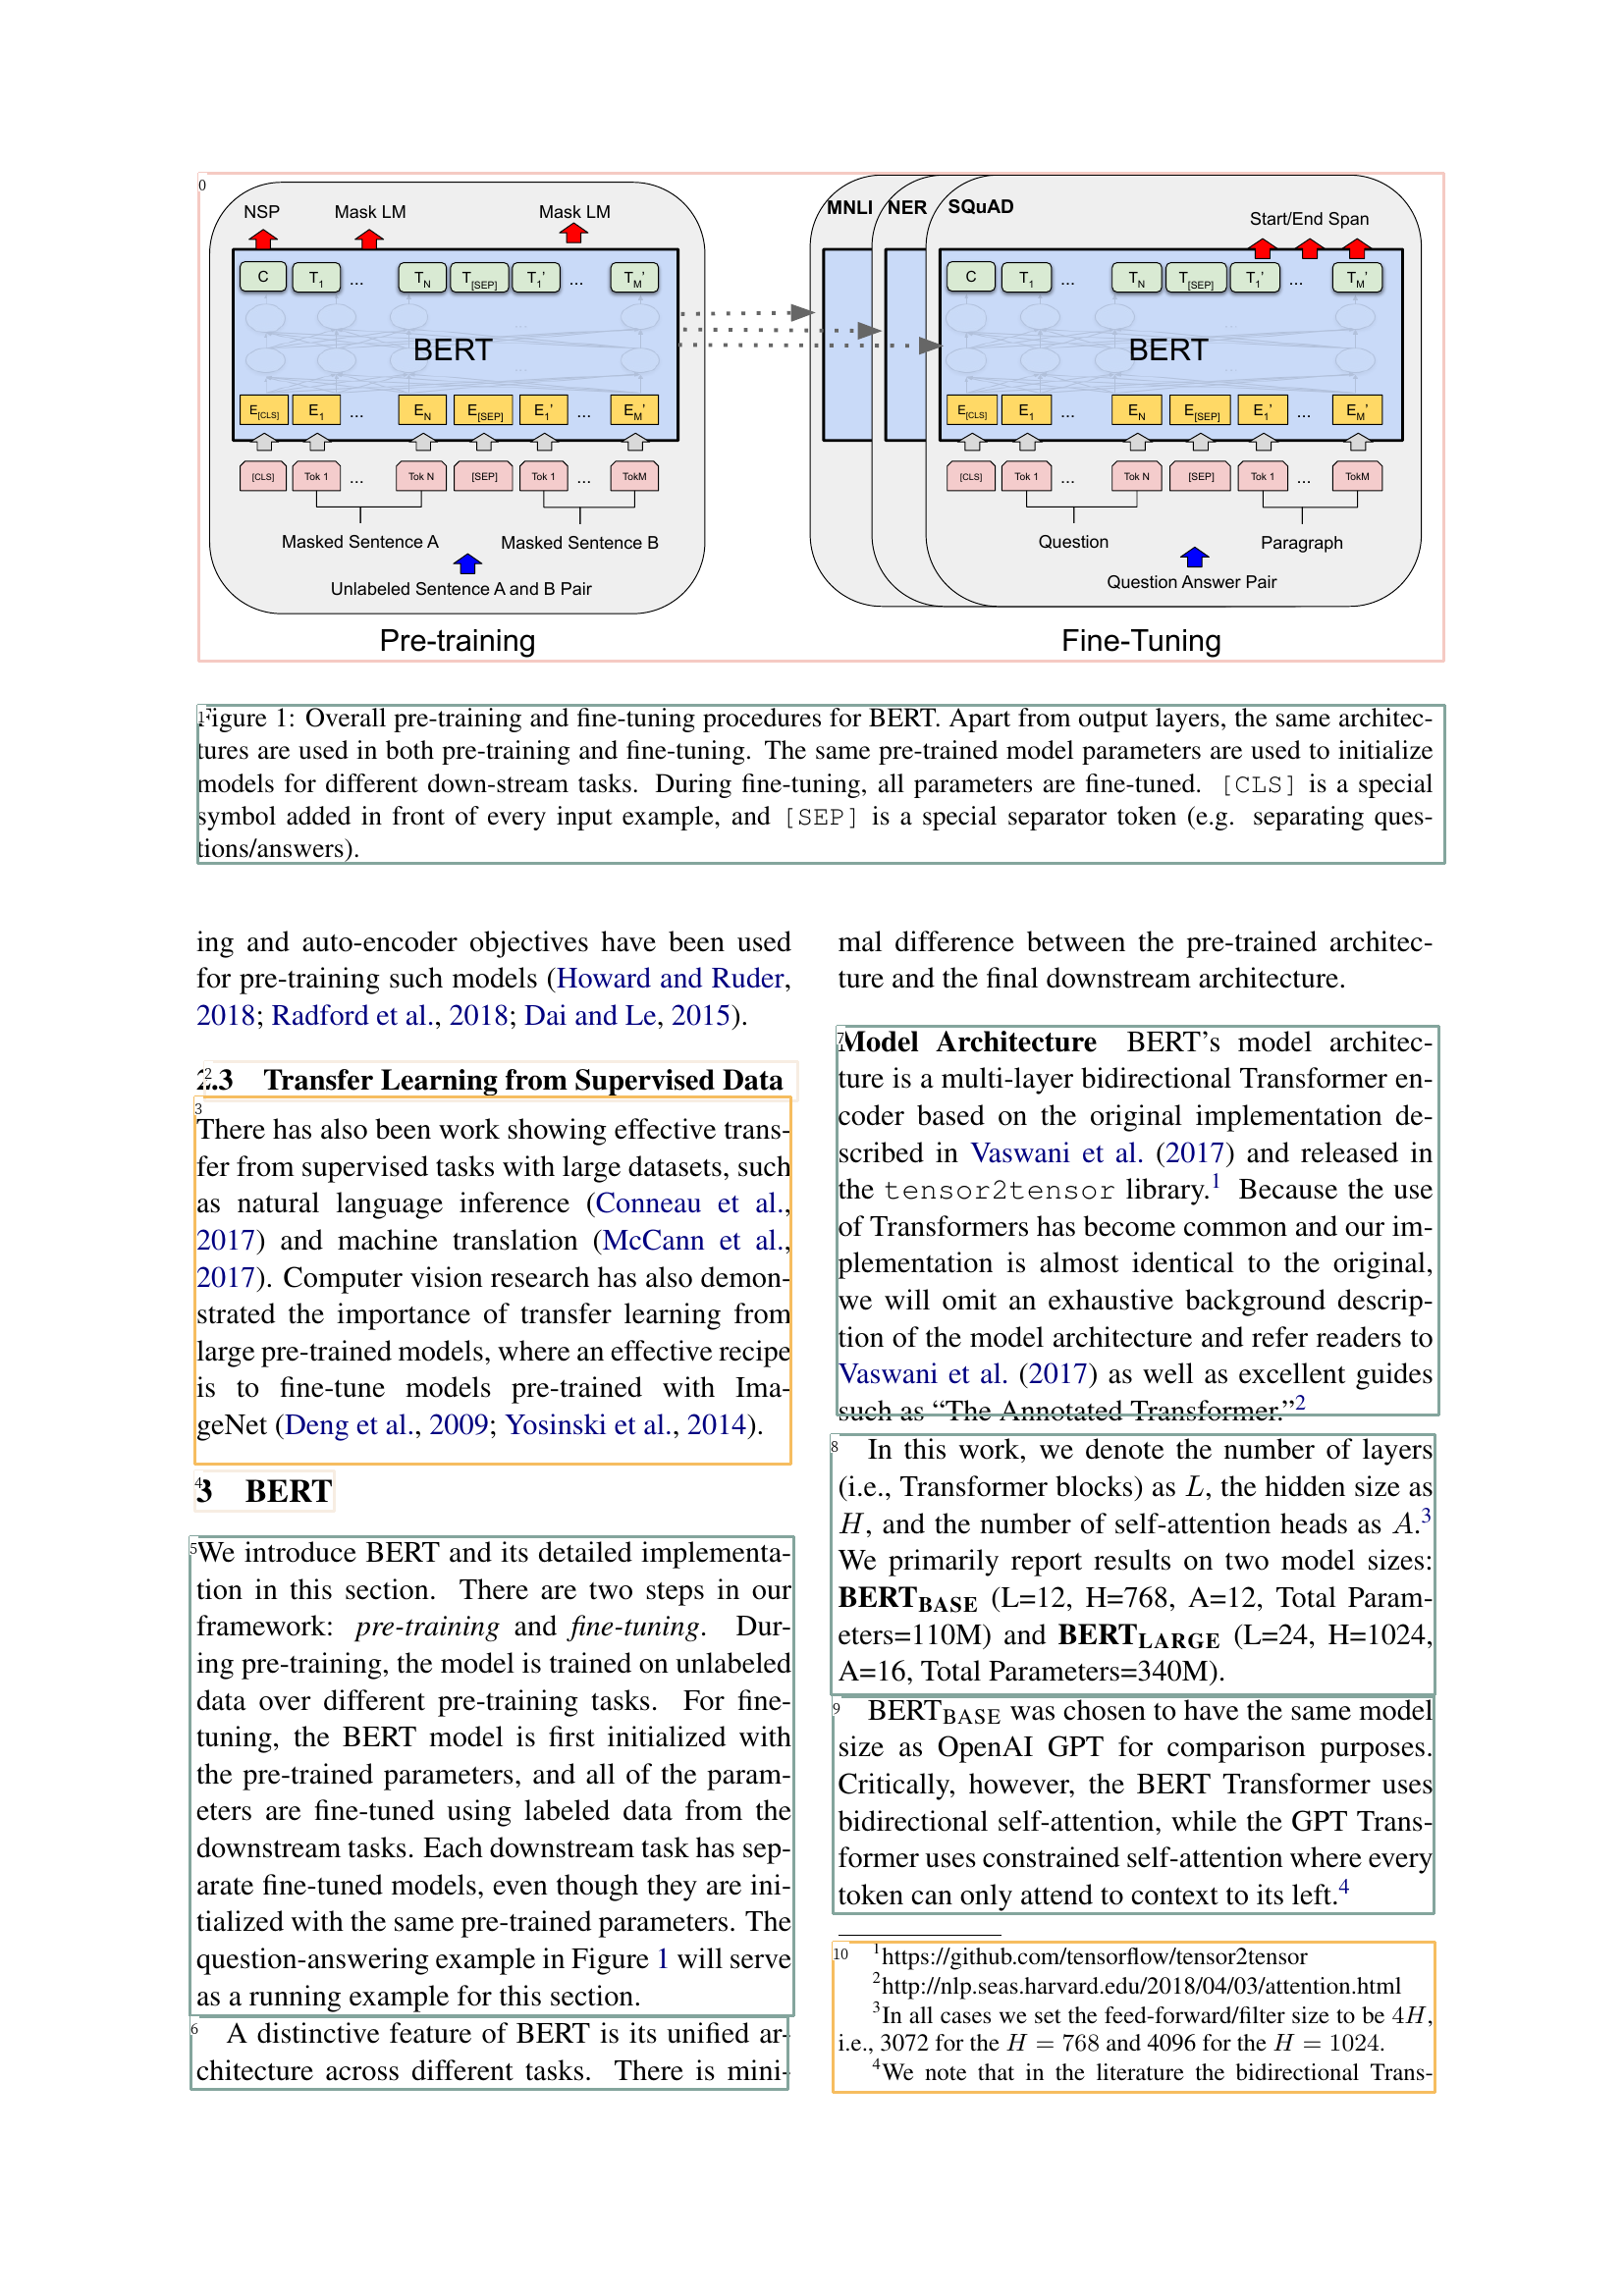

In [5]:
lp.draw_box(image_list[2], layout_list[2], box_width=3, show_element_id=True)

In [6]:
layout_list[3][2]

TextBlock(block=Rectangle(x_1=198.03793334960938, y_1=1164.90087890625, x_2=808.7883911132812, y_2=1308.256591796875), text=For a given token, its input representation is
constructed by summing the corresponding token,
segment, and position embeddings. A visualiza-
tion of this construction can be seen in Figure 2.
, id=2, type=Text, parent=None, next=None, score=0.9462326765060425)

In [7]:
# check all titles
title_text = ""
for page in layout_list:
    for element in page:
        if element.type == 'Title':
            title_text += element.text 
            
print(title_text)

BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding
2. Unsupervised Fine-tuning Approaches
2.3 Transfer Learning from Supervised Data
3. BERT
3.1 Pre-training BERT
3.2 Fine-tuning BERT
4 Experiments
4.3 SQuAD v2.0
4.4 SWAG
5 Ablation Studies
5.1 Effect of Pre-training Tasks
5.2 Effect of Model Size
3.3 Feature-based Approach with BERT
5 Conclusion



In [8]:
len(layout_list[2])

11

In [9]:
from PIL import Image
import numpy as np
# # save raw_text
# raw_text = ""
# a dictionary to store the {image : image_discription}
image_discription_dict = {}

for i, page in enumerate(layout_list):
    for j, element in enumerate(page):
        # get rid of the reference part
        if element.type == 'Text' and element.text == 'References\n':
            break
        if element.type == 'Text' or element.type == 'Title' or element.type == 'List': # List会包括进很多references
            #raw_text += element.text + "\n"
            continue
        else:
            # save the element as a .png file
            file_name = f"other_images/{element.type}_{i}_{j}.png"
            image_array = element.crop_image(image_list[i])
            # image = Image.fromarray(image_list[i])
            # cropped_image = image.crop()


            image = Image.fromarray(image_array)
            # width = 365
            # # a_r means original aspect ratio
            # a_r = image.size[0] / image.size[1]
            
            # if a_r < 4:
            # # print(image.size[0] / image.size[1])

            #     wpercent = (width/float(image.size[0]))
            #     hsize = int((float(image.size[1])*float(wpercent)))
            #     resized_image = image.resize((width, hsize))

            #     # image.save(file_name)
            #     resized_image.save(file_name)
            # else:
            image.save(file_name)

            image_discription = F.get_image_discription(page, j)
            image_discription_dict[file_name] = image_discription
         

In [10]:
## IMPORTANT
image_discription_text = repr(image_discription_dict)
#image_discription_text = json.dumps(image_discription_dict)
## save the image_discription_text as txt file
with open("image_discription_text.txt", "w") as file:
    file.write(image_discription_text)

image_discription_dict

{'other_images/Figure_2_0.png': 'Figure 1: Overall pre-training and fine-tuning procedures for BERT. Apart from output layers, the same architec-\ntures are used in both pre-training and fine-tuning. The same pre-trained model parameters are used to initialize\nmodels for different down-stream tasks. During fine-tuning, all parameters are fine-tuned. [CLS] is a special\n\nsymbol added in front of every input example, and [SEP] is a special separator token (e.g. separating ques-\ntions/answers).\n',
 'other_images/Figure_4_0.png': 'Figure 2: BERT input representation. The input embeddings are the sum of the token embeddings, the segmenta-\ntion embeddings and the position embeddings.\n',
 'other_images/Figure_6_0.png': 'Table 2: SQuAD 1.1 results. The BERT ensemble\nis 7x systems which use different pre-training check-\npoints and fine-tuning seeds.\n',
 'other_images/Figure_6_8.png': 'Table 4: SWAG Dev and Test accuracies. ‘Human per-\nformance is measured with 100 samples, as reported

In [11]:
import pandas as pd
# convert the image_discription_dict to a dataframe
image_discription_df = pd.DataFrame.from_dict(image_discription_dict, orient='index')
image_discription_df.reset_index(inplace=True)
image_discription_df.columns = ['image', 'discription']
image_discription_df


,image,discription
0,other_images/Figure_2_0.png,Figure 1: Overall pre-training and fine-tuning...
1,other_images/Figure_4_0.png,Figure 2: BERT input representation. The input...
2,other_images/Figure_6_0.png,Table 2: SQuAD 1.1 results. The BERT ensemble\...
3,other_images/Figure_6_8.png,Table 4: SWAG Dev and Test accuracies. ‘Human ...
4,other_images/Figure_7_0.png,Table 5: Ablation over the pre-training tasks ...
5,other_images/Table_8_3.png,Table 6: Ablation over BERT model size. #L = t...
6,other_images/Figure_8_5.png,Table 7: CoNLL-2003 Named Entity Recognition r...
7,other_images/Figure_12_0.png,Figure 3: Differences in pre-training model ar...
8,other_images/Figure_14_0.png,Figure 4: Illustrations of Fine-tuning BERT on...
9,other_images/Figure_14_6.png,


In [12]:
def get_the_key(discription):
    return discription[:9] #数出来的

In [13]:
# extract the key words from the image discription text and save it as new column
image_discription_df['key_words'] = image_discription_df['discription'].apply(get_the_key)
image_discription_df

,image,discription,key_words
0,other_images/Figure_2_0.png,Figure 1: Overall pre-training and fine-tuning...,Figure 1:
1,other_images/Figure_4_0.png,Figure 2: BERT input representation. The input...,Figure 2:
2,other_images/Figure_6_0.png,Table 2: SQuAD 1.1 results. The BERT ensemble\...,Table 2:
3,other_images/Figure_6_8.png,Table 4: SWAG Dev and Test accuracies. ‘Human ...,Table 4:
4,other_images/Figure_7_0.png,Table 5: Ablation over the pre-training tasks ...,Table 5:
5,other_images/Table_8_3.png,Table 6: Ablation over BERT model size. #L = t...,Table 6:
6,other_images/Figure_8_5.png,Table 7: CoNLL-2003 Named Entity Recognition r...,Table 7:
7,other_images/Figure_12_0.png,Figure 3: Differences in pre-training model ar...,Figure 3:
8,other_images/Figure_14_0.png,Figure 4: Illustrations of Fine-tuning BERT on...,Figure 4:
9,other_images/Figure_14_6.png,,


In [14]:
# a function to get the all the contexts of the key words
def find_contexts(raw_text, keys):
    context_list = []
    for key in keys:
        # fond the context, which is everything between two "."
        pattern = re.compile(rf'([^\.]*{re.escape(key)}[^\.]*)')
        context_list0 = pattern.findall(raw_text)
        context_list.append(context_list0)
  
    return context_list

In [15]:
def find_keys(raw_text, key):
    if key == "":
        return ""
    
    keys = [key]
    
    if key[0] == "F":
        keys = [key[:3] + '. ' + key[-2:-1], key[:-1], key] # ['Fig. 1', 'Figure 1']
    
    if key[0] == "T":
        keys = [key[:-2], key[:-1]]

    return keys
    

*It is better to use pyPDF2 to get the raw-text part, because it's more accurate*

In [16]:
# Read the PDF file
raw_text = F.extract_raw_text_from_pdf('test.pdf')

if "References" in raw_text:
    raw_text = re.sub(r'References.*$', '', raw_text)

# replace the \n with space
raw_text = raw_text.replace('\n', ' ')

In [17]:
# Print or process the extracted text as needed
print(len(raw_text.split(" ")))

10128


In [18]:
# apply find_contexts function to the key_words column and save it as new column
image_discription_df['keys'] = image_discription_df.apply(lambda x: find_keys(raw_text, x['key_words']), axis=1)
image_discription_df

,image,discription,key_words,keys
0,other_images/Figure_2_0.png,Figure 1: Overall pre-training and fine-tuning...,Figure 1:,"[Fig. 1, Figure 1, Figure 1:]"
1,other_images/Figure_4_0.png,Figure 2: BERT input representation. The input...,Figure 2:,"[Fig. 2, Figure 2, Figure 2:]"
2,other_images/Figure_6_0.png,Table 2: SQuAD 1.1 results. The BERT ensemble\...,Table 2:,"[Table 2, Table 2:]"
3,other_images/Figure_6_8.png,Table 4: SWAG Dev and Test accuracies. ‘Human ...,Table 4:,"[Table 4, Table 4:]"
4,other_images/Figure_7_0.png,Table 5: Ablation over the pre-training tasks ...,Table 5:,"[Table 5, Table 5:]"
5,other_images/Table_8_3.png,Table 6: Ablation over BERT model size. #L = t...,Table 6:,"[Table 6, Table 6:]"
6,other_images/Figure_8_5.png,Table 7: CoNLL-2003 Named Entity Recognition r...,Table 7:,"[Table 7, Table 7:]"
7,other_images/Figure_12_0.png,Figure 3: Differences in pre-training model ar...,Figure 3:,"[Fig. 3, Figure 3, Figure 3:]"
8,other_images/Figure_14_0.png,Figure 4: Illustrations of Fine-tuning BERT on...,Figure 4:,"[Fig. 4, Figure 4, Figure 4:]"
9,other_images/Figure_14_6.png,,,


In [19]:
image_discription_df['contexts'] = image_discription_df.apply(lambda x: find_contexts(raw_text, x['keys']), axis=1)
image_discription_df

,image,discription,key_words,keys,contexts
0,other_images/Figure_2_0.png,Figure 1: Overall pre-training and fine-tuning...,Figure 1:,"[Fig. 1, Figure 1, Figure 1:]","[[], [ TokM Masked Sentence A Masked Sentence..."
1,other_images/Figure_4_0.png,Figure 2: BERT input representation. The input...,Figure 2:,"[Fig. 2, Figure 2, Figure 2:]","[[], [ A visualiza- tion of this construction ..."
2,other_images/Figure_6_0.png,Table 2: SQuAD 1.1 results. The BERT ensemble\...,Table 2:,"[Table 2, Table 2:]",[[ Table 2 shows top leaderboard entries as we...
3,other_images/Figure_6_8.png,Table 4: SWAG Dev and Test accuracies. ‘Human ...,Table 4:,"[Table 4, Table 4:]","[[0 Table 4: SWAG Dev and Test accuracies, Re..."
4,other_images/Figure_7_0.png,Table 5: Ablation over the pre-training tasks ...,Table 5:,"[Table 5, Table 5:]",[[9 Table 5: Ablation over the pre-training ta...
5,other_images/Table_8_3.png,Table 6: Ablation over BERT model size. #L = t...,Table 6:,"[Table 6, Table 6:]",[[ Results on selected GLUE tasks are shown in...
6,other_images/Figure_8_5.png,Table 7: CoNLL-2003 Named Entity Recognition r...,Table 7:,"[Table 7, Table 7:]",[[5 - Table 7: CoNLL-2003 Named Entity Recogni...
7,other_images/Figure_12_0.png,Figure 3: Differences in pre-training model ar...,Figure 3:,"[Fig. 3, Figure 3, Figure 3:]","[[], [Figure 3: Differences in pre-training mo..."
8,other_images/Figure_14_0.png,Figure 4: Illustrations of Fine-tuning BERT on...,Figure 4:,"[Fig. 4, Figure 4, Figure 4:]","[[], [5 Illustrations of Fine-tuning on Differ..."
9,other_images/Figure_14_6.png,,,,[]


In [20]:
# save the image_discription_df as csv file
image_discription_df.to_csv('image_discription_df.csv', index=False)

In [21]:
# add all the keys to a list
total_keys = []
for keys in image_discription_df['keys']:
    total_keys += keys

total_keys

['Fig. 1',
 'Figure 1',
 'Figure 1:',
 'Fig. 2',
 'Figure 2',
 'Figure 2:',
 'Table 2',
 'Table 2:',
 'Table 4',
 'Table 4:',
 'Table 5',
 'Table 5:',
 'Table 6',
 'Table 6:',
 'Table 7',
 'Table 7:',
 'Fig. 3',
 'Figure 3',
 'Figure 3:',
 'Fig. 4',
 'Figure 4',
 'Figure 4:',
 'Fig. 5',
 'Figure 5',
 'Figure 5:']

## get the method_summary

In [22]:
# turn title_text into a list
title_list = title_text.split('\n')
title_list

['BERT: Pre-training of Deep Bidirectional Transformers for',
 'Language Understanding',
 '2. Unsupervised Fine-tuning Approaches',
 '2.3 Transfer Learning from Supervised Data',
 '3. BERT',
 '3.1 Pre-training BERT',
 '3.2 Fine-tuning BERT',
 '4 Experiments',
 '4.3 SQuAD v2.0',
 '4.4 SWAG',
 '5 Ablation Studies',
 '5.1 Effect of Pre-training Tasks',
 '5.2 Effect of Model Size',
 '3.3 Feature-based Approach with BERT',
 '5 Conclusion',
 '']

In [23]:
# get the summary 2: just method
method_index = gpt_function.get_method_title(title_list)

method_index

'4(3. BERT):7(4 Experiments)'

In [24]:
def extract_text_between(raw_text, start_session, end_session):
    # # avoid if there's special character in the title
    # start_session = re.escape(start_session)
    # end_session = re.escape(end_session)
    
    
    start_index = raw_text.find(start_session)
    end_index = raw_text.find(end_session)

    if start_index != -1 and end_index != -1:
        extracted_text = raw_text[start_index + len(start_session):end_index]
        return extracted_text
    else:
        # remove "." in the start_session and end_session
        start_session = start_session.replace(".", "")
        end_session = end_session.replace(".", "")
        start_index = raw_text.find(start_session)
        end_index = raw_text.find(end_session)
        extracted_text = raw_text[start_index + len(start_session):end_index]
        return extracted_text

In [25]:
# start title : end title
start_index0 = method_index.split(":")[0]
# remove the braket and the text inside from the start_index0
start_index = start_index0.split("(")[0]

end_index0 = method_index.split(":")[1]
end_index = end_index0.split("(")[0]

start_session = title_list[int(start_index)]
end_session = title_list[int(end_index)]

print("start_session: ", start_session)
print("end_session: ", end_session)

# # avoid if there's special character in the title
# start_session = re.escape(start_session)
# end_session = re.escape(end_session)

# pattern = re.compile(rf'{start_session}(.*?){end_session}', re.DOTALL)
# matches = pattern.findall(raw_text)

# if matches:
#     method_text = matches[0]
#     print(method_text)
# else:
#     print("No match found.")

method_text = extract_text_between(raw_text, start_session, end_session)
print(method_text)

start_session:  3. BERT
end_session:  4 Experiments
 We introduce BERT and its detailed implementa- tion in this section. There are two steps in our framework: pre-training and ﬁne-tuning . Dur- ing pre-training, the model is trained on unlabeled data over different pre-training tasks. For ﬁne- tuning, the BERT model is ﬁrst initialized with the pre-trained parameters, and all of the param- eters are ﬁne-tuned using labeled data from the downstream tasks. Each downstream task has sep- arate ﬁne-tuned models, even though they are ini- tialized with the same pre-trained parameters. The question-answering example in Figure 1 will serve as a running example for this section. A distinctive feature of BERT is its uniﬁed ar- chitecture across different tasks. There is mini-mal difference between the pre-trained architec- ture and the ﬁnal downstream architecture. Model Architecture BERT’s model architec- ture is a multi-layer bidirectional Transformer en- coder based on the original implement

In [26]:
len(method_text.split(" "))

1584

In [27]:
# keys in method_text: find the keys in the method_text
method_keys = []
for key in total_keys:
    if key in method_text:
        method_keys.append(key)

method_keys

['Figure 1', 'Figure 2', 'Figure 2:']

In [28]:

# if method_text is less than 6000, directly use get_method_summary
if len(method_text.split(" ")) < 6000:
    method_summary = gpt_function.get_method_summary(method_text, method_keys)

# if method_text is more than 2000, first slpit the method_text into 1000 words each with 200 words overlap and send to gpt one by one and get a list of summary
else:
    # this is a tricky way.xxxxxxxxxxxxxxx
    method_text2 = method_text.split(" ")[:6000]
    method_summary = gpt_function.get_method_summary(method_text, method_keys)



method_summary

'BERT (Bidirectional Encoder Representations from Transformers) is a language model that has two key stages: pre-training and fine-tuning. In the pre-training phase, the model is trained on a range of tasks without labeled data. The fine-tuning phase involves using labeled data from specific tasks, which is where the pre-trained parameters of the BERT model are fine-tuned for targeted performance. \n\nA key feature of BERT is its model architecture, which is a multi-layer bidirectional Transformer encoder. The number of layers is represented as L, the hidden size as H, and the number of self-attention heads as A. Two model sizes are used: BERT BASE and BERT LARGE. The main distinction between these is that BERT uses bidirectional self-attention while other models use self-attention that only conditions to the context on the left of each token.\n\nBERT\'s input representation allows for representation of both single sentences or pairs of sentences. The first token in every sequence is a

In [29]:
print(method_text)

 We introduce BERT and its detailed implementa- tion in this section. There are two steps in our framework: pre-training and ﬁne-tuning . Dur- ing pre-training, the model is trained on unlabeled data over different pre-training tasks. For ﬁne- tuning, the BERT model is ﬁrst initialized with the pre-trained parameters, and all of the param- eters are ﬁne-tuned using labeled data from the downstream tasks. Each downstream task has sep- arate ﬁne-tuned models, even though they are ini- tialized with the same pre-trained parameters. The question-answering example in Figure 1 will serve as a running example for this section. A distinctive feature of BERT is its uniﬁed ar- chitecture across different tasks. There is mini-mal difference between the pre-trained architec- ture and the ﬁnal downstream architecture. Model Architecture BERT’s model architec- ture is a multi-layer bidirectional Transformer en- coder based on the original implementation de- scribed in Vaswani et al. (2017) and relea

In [30]:
method_summary = "### Detailed Method:\n\n"  + method_summary

In [31]:
print(title_text)

BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding
2. Unsupervised Fine-tuning Approaches
2.3 Transfer Learning from Supervised Data
3. BERT
3.1 Pre-training BERT
3.2 Fine-tuning BERT
4 Experiments
4.3 SQuAD v2.0
4.4 SWAG
5 Ablation Studies
5.1 Effect of Pre-training Tasks
5.2 Effect of Model Size
3.3 Feature-based Approach with BERT
5 Conclusion



In [32]:
len(method_text.split(" "))

1584

In [33]:
len(method_summary.split(" "))

344

In [34]:
print(method_summary)

### Detailed Method:

BERT (Bidirectional Encoder Representations from Transformers) is a language model that has two key stages: pre-training and fine-tuning. In the pre-training phase, the model is trained on a range of tasks without labeled data. The fine-tuning phase involves using labeled data from specific tasks, which is where the pre-trained parameters of the BERT model are fine-tuned for targeted performance. 

A key feature of BERT is its model architecture, which is a multi-layer bidirectional Transformer encoder. The number of layers is represented as L, the hidden size as H, and the number of self-attention heads as A. Two model sizes are used: BERT BASE and BERT LARGE. The main distinction between these is that BERT uses bidirectional self-attention while other models use self-attention that only conditions to the context on the left of each token.

BERT's input representation allows for representation of both single sentences or pairs of sentences. The first token in eve

## Get the genral summary

In [35]:
#get summary 1: without method
# QA_pair is a dictionary {question: answer}
_, summary, filtered_QA_pair = gpt_function.generate_summary(raw_text, api_key)

get all the QA pairs
get the initial summary


In [36]:
filtered_QA_pair

{'Research Problem': 'The paper is addressing the problem of question answering tasks, specifically predicting the answer text span in a passage given a question and a passage from Wikipedia containing the answer. The problem setting involves representing the input question and passage as a single packed sequence, with the question using the A embedding and the passage using the B embedding. The paper also addresses the issue of questions that do not have an answer in the provided paragraph, making the problem more realistic. Another problem discussed is the limitation of standard language models being unidirectional, which restricts the choice of architectures that can be used during pre-training and could be harmful when applying fine-tuning based approaches to token-level tasks such as question answering.',
 'Contribution': 'The main contributions of the paper are the generalization of findings to deep bidirectional architectures, allowing the same pre-trained model to successfully 

In [37]:
summary

"### Overview:\n\nThe paper tackles the problematic area of question answering tasks from passages in Wikipedia, addressing the specific prediction of an answer text span within a given passage and tackling unanswerable questions. BERT, a novel, conceptually simple yet potent model, is presented as the paper's primary contribution. BERT is optimized for deep bidirectional architectures, offering applicability across a wide range of Natural Language Processing tasks, exemplified by achieving state-of-the-art results across eleven such tasks. The paper utilizes various datasets, such as the GLUE benchmark, SQuAD v1.1, and the SWAG dataset. Ablation studies were conducted to explore aspects of BERT and the importance of its deep bidirectionality was a notable discovery. Despite various model alterations, BERT's effectiveness remained evident, particularly for Named Entity Recognition tasks. The paper concludes by affirming BERT's simplicity and efficacy in achieving exceptional results on

In [38]:
print(summary)

### Overview:

The paper tackles the problematic area of question answering tasks from passages in Wikipedia, addressing the specific prediction of an answer text span within a given passage and tackling unanswerable questions. BERT, a novel, conceptually simple yet potent model, is presented as the paper's primary contribution. BERT is optimized for deep bidirectional architectures, offering applicability across a wide range of Natural Language Processing tasks, exemplified by achieving state-of-the-art results across eleven such tasks. The paper utilizes various datasets, such as the GLUE benchmark, SQuAD v1.1, and the SWAG dataset. Ablation studies were conducted to explore aspects of BERT and the importance of its deep bidirectionality was a notable discovery. Despite various model alterations, BERT's effectiveness remained evident, particularly for Named Entity Recognition tasks. The paper concludes by affirming BERT's simplicity and efficacy in achieving exceptional results on mu

In [39]:
len(summary.split(" "))

153

In [40]:
print(method_summary)

### Detailed Method:

BERT (Bidirectional Encoder Representations from Transformers) is a language model that has two key stages: pre-training and fine-tuning. In the pre-training phase, the model is trained on a range of tasks without labeled data. The fine-tuning phase involves using labeled data from specific tasks, which is where the pre-trained parameters of the BERT model are fine-tuned for targeted performance. 

A key feature of BERT is its model architecture, which is a multi-layer bidirectional Transformer encoder. The number of layers is represented as L, the hidden size as H, and the number of self-attention heads as A. Two model sizes are used: BERT BASE and BERT LARGE. The main distinction between these is that BERT uses bidirectional self-attention while other models use self-attention that only conditions to the context on the left of each token.

BERT's input representation allows for representation of both single sentences or pairs of sentences. The first token in eve

In [41]:
len(method_summary.split(" "))

344

### combine summary and method_summary to V1_summary

In [42]:
# # use re get the text texts between '## Methodology' and next '##'
# import re
# pattern = re.compile(r'(?<=## Methodology).*?(?=##)', re.S)
# replace_text = pattern.findall(summary)[0]
# test_method_summary = method_summary[3:]
# # replace the replace_text with the method_summary to get V1_summary
# V1_summary = summary.replace(replace_text, test_method_summary + "\n\n")
# print(V1_summary)
V1_summary = summary + "\n\n" + method_summary

In [43]:
## add the title and some metadata
paper_title = ""
for item in title_list:
    # if the first letter of the item is a number, break
    if item[0].isnumeric():
        break
    else:
        paper_title += str(item)

paper_title = "# " + paper_title + "\n\n"

print(paper_title)

# BERT: Pre-training of Deep Bidirectional Transformers forLanguage Understanding




In [44]:
V1_summary0 = paper_title + V1_summary
print(V1_summary0)

# BERT: Pre-training of Deep Bidirectional Transformers forLanguage Understanding

### Overview:

The paper tackles the problematic area of question answering tasks from passages in Wikipedia, addressing the specific prediction of an answer text span within a given passage and tackling unanswerable questions. BERT, a novel, conceptually simple yet potent model, is presented as the paper's primary contribution. BERT is optimized for deep bidirectional architectures, offering applicability across a wide range of Natural Language Processing tasks, exemplified by achieving state-of-the-art results across eleven such tasks. The paper utilizes various datasets, such as the GLUE benchmark, SQuAD v1.1, and the SWAG dataset. Ablation studies were conducted to explore aspects of BERT and the importance of its deep bidirectionality was a notable discovery. Despite various model alterations, BERT's effectiveness remained evident, particularly for Named Entity Recognition tasks. The paper concludes

In [45]:
len(V1_summary0.split(" "))

504

In [46]:
# save V1_summary to txt
with open("V1_summary.md", "w") as f:
    f.write(V1_summary0)

In [47]:
print("finish runing get_V1.ipynb")

finish runing get_V1.ipynb


In [48]:
method_summary = re.split('### Detailed Method:', V1_summary)[1]
# save method_summary to md
with open("method_summary.md", "w") as f:
    f.write(method_summary)